In [26]:
from poloniex import Poloniex
from tusp import string2ts, ts2string
import json
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

polo = Poloniex()

# historyData es una lista de diccionarios python
# candlestick period in seconds; valid values are 300, 900, 1800, 7200, 14400, and 86400
historyData = polo.returnChartData(currencyPair="BTC_XRP",
                     start=string2ts("2017-06-01 00:00:00"),
                     end=string2ts("2017-09-01 0:00:00"),
                     period=3600*4)

# Guardando los datos como lista de diccionarios en un archivo de texto
# esto permite acceder a ellos y trabajar como data frame offline
with open("XMR_data.out","w") as f:
    json.dump(historyData,f)
    
with open("XMR_data.out") as f:
    historyData = json.load(f)
    #print data

# convirtiendo datos en data frame
df = pd.DataFrame(historyData)

#  convirtiendo string a float o int
df["close"] =pd.to_numeric(df['close'])
df["open"] =pd.to_numeric(df['open'])
df["low"] =pd.to_numeric(df['high'])
df["volume"] =pd.to_numeric(df['volume'])
df["date"] = pd.to_datetime(df["date"].apply(ts2string))

# seleccionando la columna de fecha como indice
df = df.set_index("date")

# examinando las primeras filas
df.head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-06-01 03:00:00,0.000130,0.000134,0.000134,0.000133,188296429.27898,24012.038470,0.00012752
2017-06-01 07:00:00,0.000124,0.00013086,0.000131,0.000130,99985690.98589,12696.206164,0.00012698
2017-06-01 11:00:00,0.000130,0.000131,0.000131,0.000124,66217958.217282,8285.644707,0.00012512
2017-06-01 15:00:00,0.000139,0.00014348,0.000143,0.000130,122467406.24928,16687.692523,0.00013626
2017-06-01 19:00:00,0.000135,0.00014044,0.000140,0.000139,68937700.568858,9338.146821,0.00013545


# Calculando retornos, log retornos y sus respectivos acumulados

Retorno final del mercado: -58.9298123697


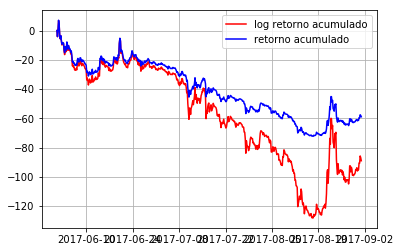

In [27]:
# Calculando retornos relativos
# el 1 se refiere al numero de periodos que se toma para calcular el cambio porcentual
df["retornos relativos"] = df["close"].pct_change(1).fillna(0)

# calculando los log retornos
df["log retornos"] = np.log(df["close"]).diff().fillna(0)

# calculando log retorno acumulado
df["cum_logr"] = df["log retornos"].cumsum()
df["cum_r"] = np.exp(df["cum_logr"]) - 1

plt.plot(df.index,df['cum_logr']*100,'r',label='log retorno acumulado')
plt.plot(df.index,df['cum_r']*100,'b', label='retorno acumulado')
plt.legend()
plt.grid()
#df.isnull().any()
#df[df['retornos relativos'].isnull()]
print "Retorno final del mercado: %s"%(df["cum_r"][-1]*100)

# Ejemplo estrategía, media movil

Las estrategías funcionan como funciones que como parámetro reciben una serie de pandas o una lista de tamaño $T$ (intervalo de tiempo de estudio divido en el periodo de interés), y devuelven el vector de pesos $\vec{w}$ de tamaño $T\times 2$ y que contiene solo ceros o unos (1 si se posee el determinado activo, 0 si no). La primera columna de $\vec{w}$ corresponde a la posesión del activo de interés, la segunda a la posesión de la moneda por la que se tranza (generalmente **BTC**) 

El retorno relativo con la estrategia EMA5 VS SMA20 fue: 6.15924731096
0.0001242
5.319e-05
                    orders    w  logReturn  logReturn*w  cumLogReturn
date                                                                 
2017-06-15 07:00:00   WAIT  1.0   0.016638     0.016638      0.088091
2017-06-15 11:00:00   WAIT  1.0  -0.005194    -0.005194      0.082897
2017-06-15 15:00:00   WAIT  1.0  -0.024403    -0.024403      0.058494
2017-06-15 19:00:00   SELL  1.0  -0.004060    -0.004060      0.054434
2017-06-15 23:00:00   WAIT  0.0   0.011149     0.000000      0.054434
2017-06-16 03:00:00   WAIT  0.0   0.000785     0.000000      0.054434
2017-06-16 07:00:00   WAIT  0.0  -0.006097    -0.000000      0.054434
2017-06-16 11:00:00   WAIT  0.0  -0.002865    -0.000000      0.054434
2017-06-16 15:00:00   WAIT  0.0  -0.001485    -0.000000      0.054434
2017-06-16 19:00:00   WAIT  0.0  -0.023556    -0.000000      0.054434
2017-06-16 23:00:00   WAIT  0.0   0.016697     0.000000      0.054434

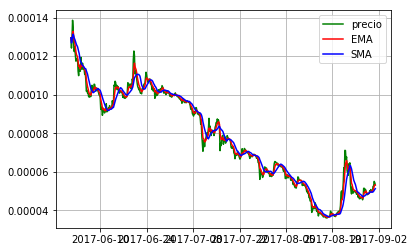

In [32]:
from profit import profit,change5
from orders import orders

# dada una serie de pandas o una lista y el numero de muestras para la EMA y SMA devuelve vector w
# considerando el cruce entre EMA y SMA
def estrategiaEMAvsSMA(serie, smaPeriod=13,emaPeriod=5):
    
    # Calculando media movil a 20 muestras
    sma = serie.rolling(smaPeriod,min_periods=1).mean()
    # caculando exponential movil average
    ema = serie.ewm(span=emaPeriod, adjust=False).mean()
    
    # Encontrando el signo de la resta entre ellas para encontrar los cruces
    dif = (ema - sma).apply(np.sign)
    
    w = pd.DataFrame(data={"w":(dif+1)/2})
    
    w['w'] = w['w'].apply(change5)
    
    w["orders"] = orders(w["w"])
    w['w'] = w['w'].shift(1)
    w["price"] = serie
    
    plt.plot(df.index[:],df['close'][:],'g',label='precio')
    plt.plot(df.index[:],ema[:],'r',label='EMA')
    plt.plot(df.index[:],sma[:],'b',label='SMA')
    plt.legend(loc='best')
    plt.grid()
    
    return w



w = estrategiaEMAvsSMA(df['close'])
relativeReturn, vecReturn = profit(w)

#plt.plot(df.index,vecReturn,'g',label='retorno')


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(vecReturn[-1]*100)

print w[w["orders"] == "BUY"]["price"][0]
#print w["Return"][0],w["Return"][-1],w["price"][0],w["price"][-1]
print w["price"][-1]
#print w[w["orders"] != "WAIT"]
print w.loc["2017-06-15 07:00:00":"2017-06-20 00:00:00",["orders","w","logReturn","logReturn*w","cumLogReturn"]]

In [29]:
from strategy import pricevsEMA, pricevsSMA, EMAvsEMA

#Precio vs EMA_5

w = pricevsEMA(df["close"])
relativeReturn,v = profit(w)

w["price_profit"] = w["price"]
w.loc[w["orders"] == "BUY","price_profit"] = w[w["orders"] == "BUY"]["price"]*-1
w.loc[w["orders"] == "WAIT","price_profit"] = 0

print ((w["price_profit"].sum()+w["price"][-1])/w[w["orders"] == "BUY"]["price"][0])*100

print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)
print w.head()

-8.68291178285
El retorno relativo con la estrategia EMA5 VS SMA20 fue: 2.15173860695
                       w orders     price  logReturn  logReturn*w  \
date                                                                
2017-06-01 03:00:00  NaN   WAIT  0.000130   0.000000          NaN   
2017-06-01 07:00:00  0.0   WAIT  0.000124  -0.041865    -0.000000   
2017-06-01 11:00:00  0.0    BUY  0.000130   0.043177     0.000000   
2017-06-01 15:00:00  1.0   WAIT  0.000139   0.066883     0.066883   
2017-06-01 19:00:00  1.0   WAIT  0.000135  -0.026752    -0.026752   

                     cumLogReturn    return  price_profit  
date                                                       
2017-06-01 03:00:00           NaN       NaN       0.00000  
2017-06-01 07:00:00      0.000000  0.000000       0.00000  
2017-06-01 11:00:00      0.000000  0.000000      -0.00013  
2017-06-01 15:00:00      0.066883  0.069170       0.00000  
2017-06-01 19:00:00      0.040131  0.040947       0.00000  


El retorno relativo con la estrategia EMA5 VS SMA20 fue: 19.5334621081


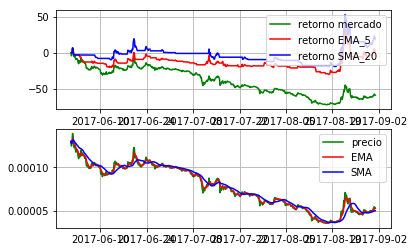

In [30]:
#Precio vs SMA_20

w2 = pricevsSMA(df["close"])
relativeReturn,v2 = profit(w2)

# Calculando media movil a 20 muestras
sma = df["close"].rolling(20,min_periods=1).mean()
# caculando exponential movil average
ema = df["close"].ewm(span=5, adjust=False).mean()

plt.subplot(211)
plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v*100,'r',label='retorno EMA_5')
plt.plot(df.index,v2*100,'b',label='retorno SMA_20')
plt.legend(loc='best')
plt.grid()

plt.subplot(212)
plt.plot(df.index,df['close'],'g',label='precio')
plt.plot(df.index,ema,'r',label='EMA')
plt.plot(df.index,sma,'b',label='SMA')
plt.legend(loc='best')
plt.grid()


print 'El retorno relativo con la estrategia EMA5 VS SMA20 fue: %s'%(relativeReturn*100)

In [31]:
#EMA_5 vs EMA_20

w = EMAvsEMA(df["close"])
relativeReturn,v = profit(w)

print 'El retorno relativo con la estrategia EMA5 VS EMA20 fue: %s'%(relativeReturn*100)

El retorno relativo con la estrategia EMA5 VS EMA20 fue: -31.6914455895
